In [2]:
import os 
from requests import get 
import numpy as np 
import pandas as pd 
from bs4 import BeautifulSoup
import time as time 
from tqdm.notebook import tqdm

In [3]:
#----- PLOTTING PARAMS ----# 
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns

sns.set(style="whitegrid")
%config InlineBackend.figure_format = 'retina'
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

plot_params = {
'font.size' : 22,
'axes.titlesize' : 24,
'axes.labelsize' : 20,
'axes.labelweight' : 'bold',
'xtick.labelsize' : 16,
'ytick.labelsize' : 16,
}
 
plt.rcParams.update(plot_params)

## Load Dataset

The data set for the movie was scrapped from IMDB using `BeautifulSoup`. A template for the code used for scrapping the data is shown in the cell below. 

In [ ]:
#| code-fold: true
names, year, imdb_rating, metascore, num_votes = [], [], [], [], [] 

start_time = time.time()
requests = 0

years_url = [str(i) for i in range(1950,2006)]
page_iter = [0, 51, 101, 151, 201]

for year_url in tqdm(years_url):
    for page_num in tqdm(page_iter):
        #URL to parse 
        url = 'https://www.imdb.com/search/title/?title_type=feature,&release_date={0},{0}&countries=in&languages=hi&sort=num_votes,desc&start={1}&ref_=adv_prv'.format(int(year_url), int(page_num))
        response = get(url)
        
        #Sleep to carve out load 
        time.sleep(np.random.randint(1,5))
        
        #Estimate time elapsed per request
        requests += 1
        elapsed_time = time.time() - start_time
        print('Request:{}; Frequency: {} requests/s'.format(requests, requests/elapsed_time))
        clear_output(wait = True)
        
        html_soup = BeautifulSoup(response.text, 'html.parser')
        movie_containers = html_soup.find_all('div', class_='lister-item mode-advanced')
        
        for i, container in enumerate(movie_containers):
            container_entry = movie_containers[i] 
            movie_name = container_entry.h3.a.text
            names.append(movie_name)
            
            movie_year = container_entry.h3.find('span',class_='lister-item-year text-muted unbold').text.strip('()')
            year.append(movie_year)
            #print(movie_name, movie_year)
            
            try:
                movie_rating = float(container_entry.strong.text)
                imdb_rating.append(movie_rating)
            except AttributeError:
                imdb_rating.append(np.nan)
            
            try:
                movie_votes = float(''.join(container_entry.find('span', attrs = {'name':'nv'}).text.split(',')))
                num_votes.append(movie_votes)
            except (AttributeError, ValueError):
                num_votes.append(np.nan)
                
            try:
                movie_metascore = float(container_entry.find('span', class_='metascore').text.strip())
                metascore.append(movie_metascore)
            except AttributeError:
                metascore.append(np.nan)
    
    print('Making dataframe for year {}'.format(year_url))
    df_movies = pd.DataFrame({'name':names,'year':year,'rating':imdb_rating,'metascore':metascore,'num_votes':num_votes})
    df_movies.to_csv('./temp_imdb_files/bollywood_data_{}.csv'.format(year_url),sep=',',header=True, index=False)
    del df_movies

In [40]:
df_movies = pd.read_csv('./IMDB-files/bollywood_movies_data_1950_2020_new.csv',sep=',', skipinitialspace=True)

In [5]:
df_movies.columns

Index(['name', 'year', 'rating', 'metascore', 'num_votes'], dtype='object')

In [7]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11876 entries, 0 to 11875
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       11876 non-null  object 
 1   year       11875 non-null  object 
 2   rating     7427 non-null   float64
 3   metascore  91 non-null     float64
 4   num_votes  7427 non-null   float64
dtypes: float64(3), object(2)
memory usage: 464.0+ KB


## Cleaning the data

Since we are particularly interested in release year of the movies, we can sanitize that column first. To begin, we see what are different possible strings/elements in the year.  

In [8]:
df_movies['year'].unique()

array(['1950', '1951', 'I) (1951', '1952', '1957', 'II) (1952', '1953',
       'II) (1953', 'III) (1953', 'I) (1953', '1954', 'I) (1954',
       'III) (1954', '1955', '1956', 'II) (1957', '1958', 'I) (1958',
       '1959', 'II) (1959', '1960', 'I) (1960', '1961', '1962', '1963',
       'I) (1964', '1964', '1965', '1966', '1967', '1968', 'I) (1968',
       '1969', 'I) (1969', '1979', '1970', 'II) (1970', '1971',
       'I) (1971', 'II) (1971', '1972', 'II) (1972', '1973', '1974',
       'II) (1974', '1975', 'I) (1975', 'II) (1975', '1976', '1977',
       'I) (1977', '1978', 'II) (1978', 'I) (1979', 'II) (1979', '1980',
       'I) (1980', '1981', '1982', 'I) (1982', '1983', 'I) (1983',
       'II) (1983', '1984', 'II) (1984', '1985', 'I) (1985', '1986',
       'I) (1986', 'II) (1986', '1987', 'I) (1987', '1988', 'I) (1988',
       'II) (1988', '1989', 'I) (1989', '1990', 'II) (1990', 'I) (1990',
       '1991', 'I) (1991', '1992', '1993', 'I) (1992', 'II) (1992',
       'I) (1993', 'II) (

Data pulled from the website has phantom characters alongside the dates. Hence this would need some cleaning from our end to ensure all the dates are in consistent format. 

In [9]:
df_movies.shape

(11876, 5)

I am using `strip` to loop each date entry in the dataset and strip off any residual characters which coincide with the those mentioned in the filter. Another option is to use `replace` in pandas using `regex` filters 

In [12]:
df_movies['year'] = df_movies['year'].astype('str')

In [13]:
df_movies['year']=[i.strip('IIII) XVII) ( (  TV Special  TV Mov') for i in df_movies['year'].tolist()]

Printing the data again to check for the date entries: 

In [14]:
df_movies['year'].unique()

array(['1950', '1951', '1952', '1957', '1953', '1954', '1955', '1956',
       '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965',
       '1966', '1967', '1968', '1969', '1979', '1970', '1971', '1972',
       '1973', '1974', '1975', '1976', '1977', '1978', '1980', '1981',
       '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989',
       '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997',
       '1998', '2005', '1999', '2000', '2001', '2002', '2003', '2004',
       '2007', '2006', '2008', '2009', '2012', '2010', '2011', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', 'nan'],
      dtype=object)

Consistency check for the dataframe shape to ensure no funny business

In [16]:
df_movies.shape

(11876, 5)

## Filtering out movies

Since IMDb is a fairly recent rating portal there are lot of movies especially those realeased pre 1980s which have low votes. Also IMDb lists every possible movie that was released in Hindi language. To better focus on credible movies I would filter out movies with low votes

In [17]:
votes_filter = df_movies['num_votes'] > 50 #Filter out movies which have got less than 100 votes from IMDb users 
df_movies_filter_votes = df_movies.loc[votes_filter].reset_index(drop=True) #Reset the indices of the new dataframe and drop the old ones -- if not done a different column with old index is appended 

In [18]:
df_movies_filter_votes.shape

(3912, 5)

## Convert year data entry to pandas `Datetime` object for convenience 

In [19]:
df_movies_filter_votes['year'] = pd.to_datetime(df_movies_filter_votes['year'],format='%Y').dt.year

## Analyze annual movie releases

Defining a separate dataframe for doing per-year analysis 


In [20]:
stat_list = ['year', 'total_movies_year', 'highest_rated_movie', 'movie_rating','avg_num_votes', 'avg_movie_rating']
annual_movie_stats = {keys:[] for keys in stat_list} 

for year_entry in df_movies_filter_votes['year'].unique():
    per_year_column = df_movies_filter_votes.loc[df_movies_filter_votes['year'] == year_entry]
    
    try:
        movie_entry_with_max_ratings = df_movies_filter_votes.loc[per_year_column['rating'].idxmax()]
        higest_movie_rating = movie_entry_with_max_ratings['rating']
        highest_rated_movie = movie_entry_with_max_ratings['name']
        avg_movie_rating = per_year_column['rating'].mean()
        total_movies = len(per_year_column)
        avg_num_votes = per_year_column['num_votes'].mean()
    except ValueError:
        higest_movie_rating = np.nan
        highest_rated_movie = np.nan
        total_movies = np.nan
        avg_movie_rating = np.nan 
    
    annual_movie_stats['year'].append(year_entry)
    annual_movie_stats['highest_rated_movie'].append(highest_rated_movie)
    annual_movie_stats['movie_rating'].append(higest_movie_rating)
    annual_movie_stats['avg_movie_rating'].append(avg_movie_rating)
    annual_movie_stats['total_movies_year'].append(total_movies)
    annual_movie_stats['avg_num_votes'].append(avg_num_votes)

In [21]:
df_annual_movie_stats = pd.DataFrame(annual_movie_stats, columns=annual_movie_stats.keys())

In [22]:
df_annual_movie_stats.sample(5)

,year,total_movies_year,highest_rated_movie,movie_rating,avg_num_votes,avg_movie_rating
49,1999,67,Sarfarosh,8.1,2201.328358,5.583582
3,1953,9,Do Bigha Zamin,8.4,293.000000,7.388889
69,2019,141,99 Songs,8.8,4041.056738,6.002128
9,1959,11,Kaagaz Ke Phool,8.0,329.454545,7.172727
34,1984,36,Saaransh,8.2,286.055556,6.427778


/Users/pghaneka/miniconda3/envs/doodle/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


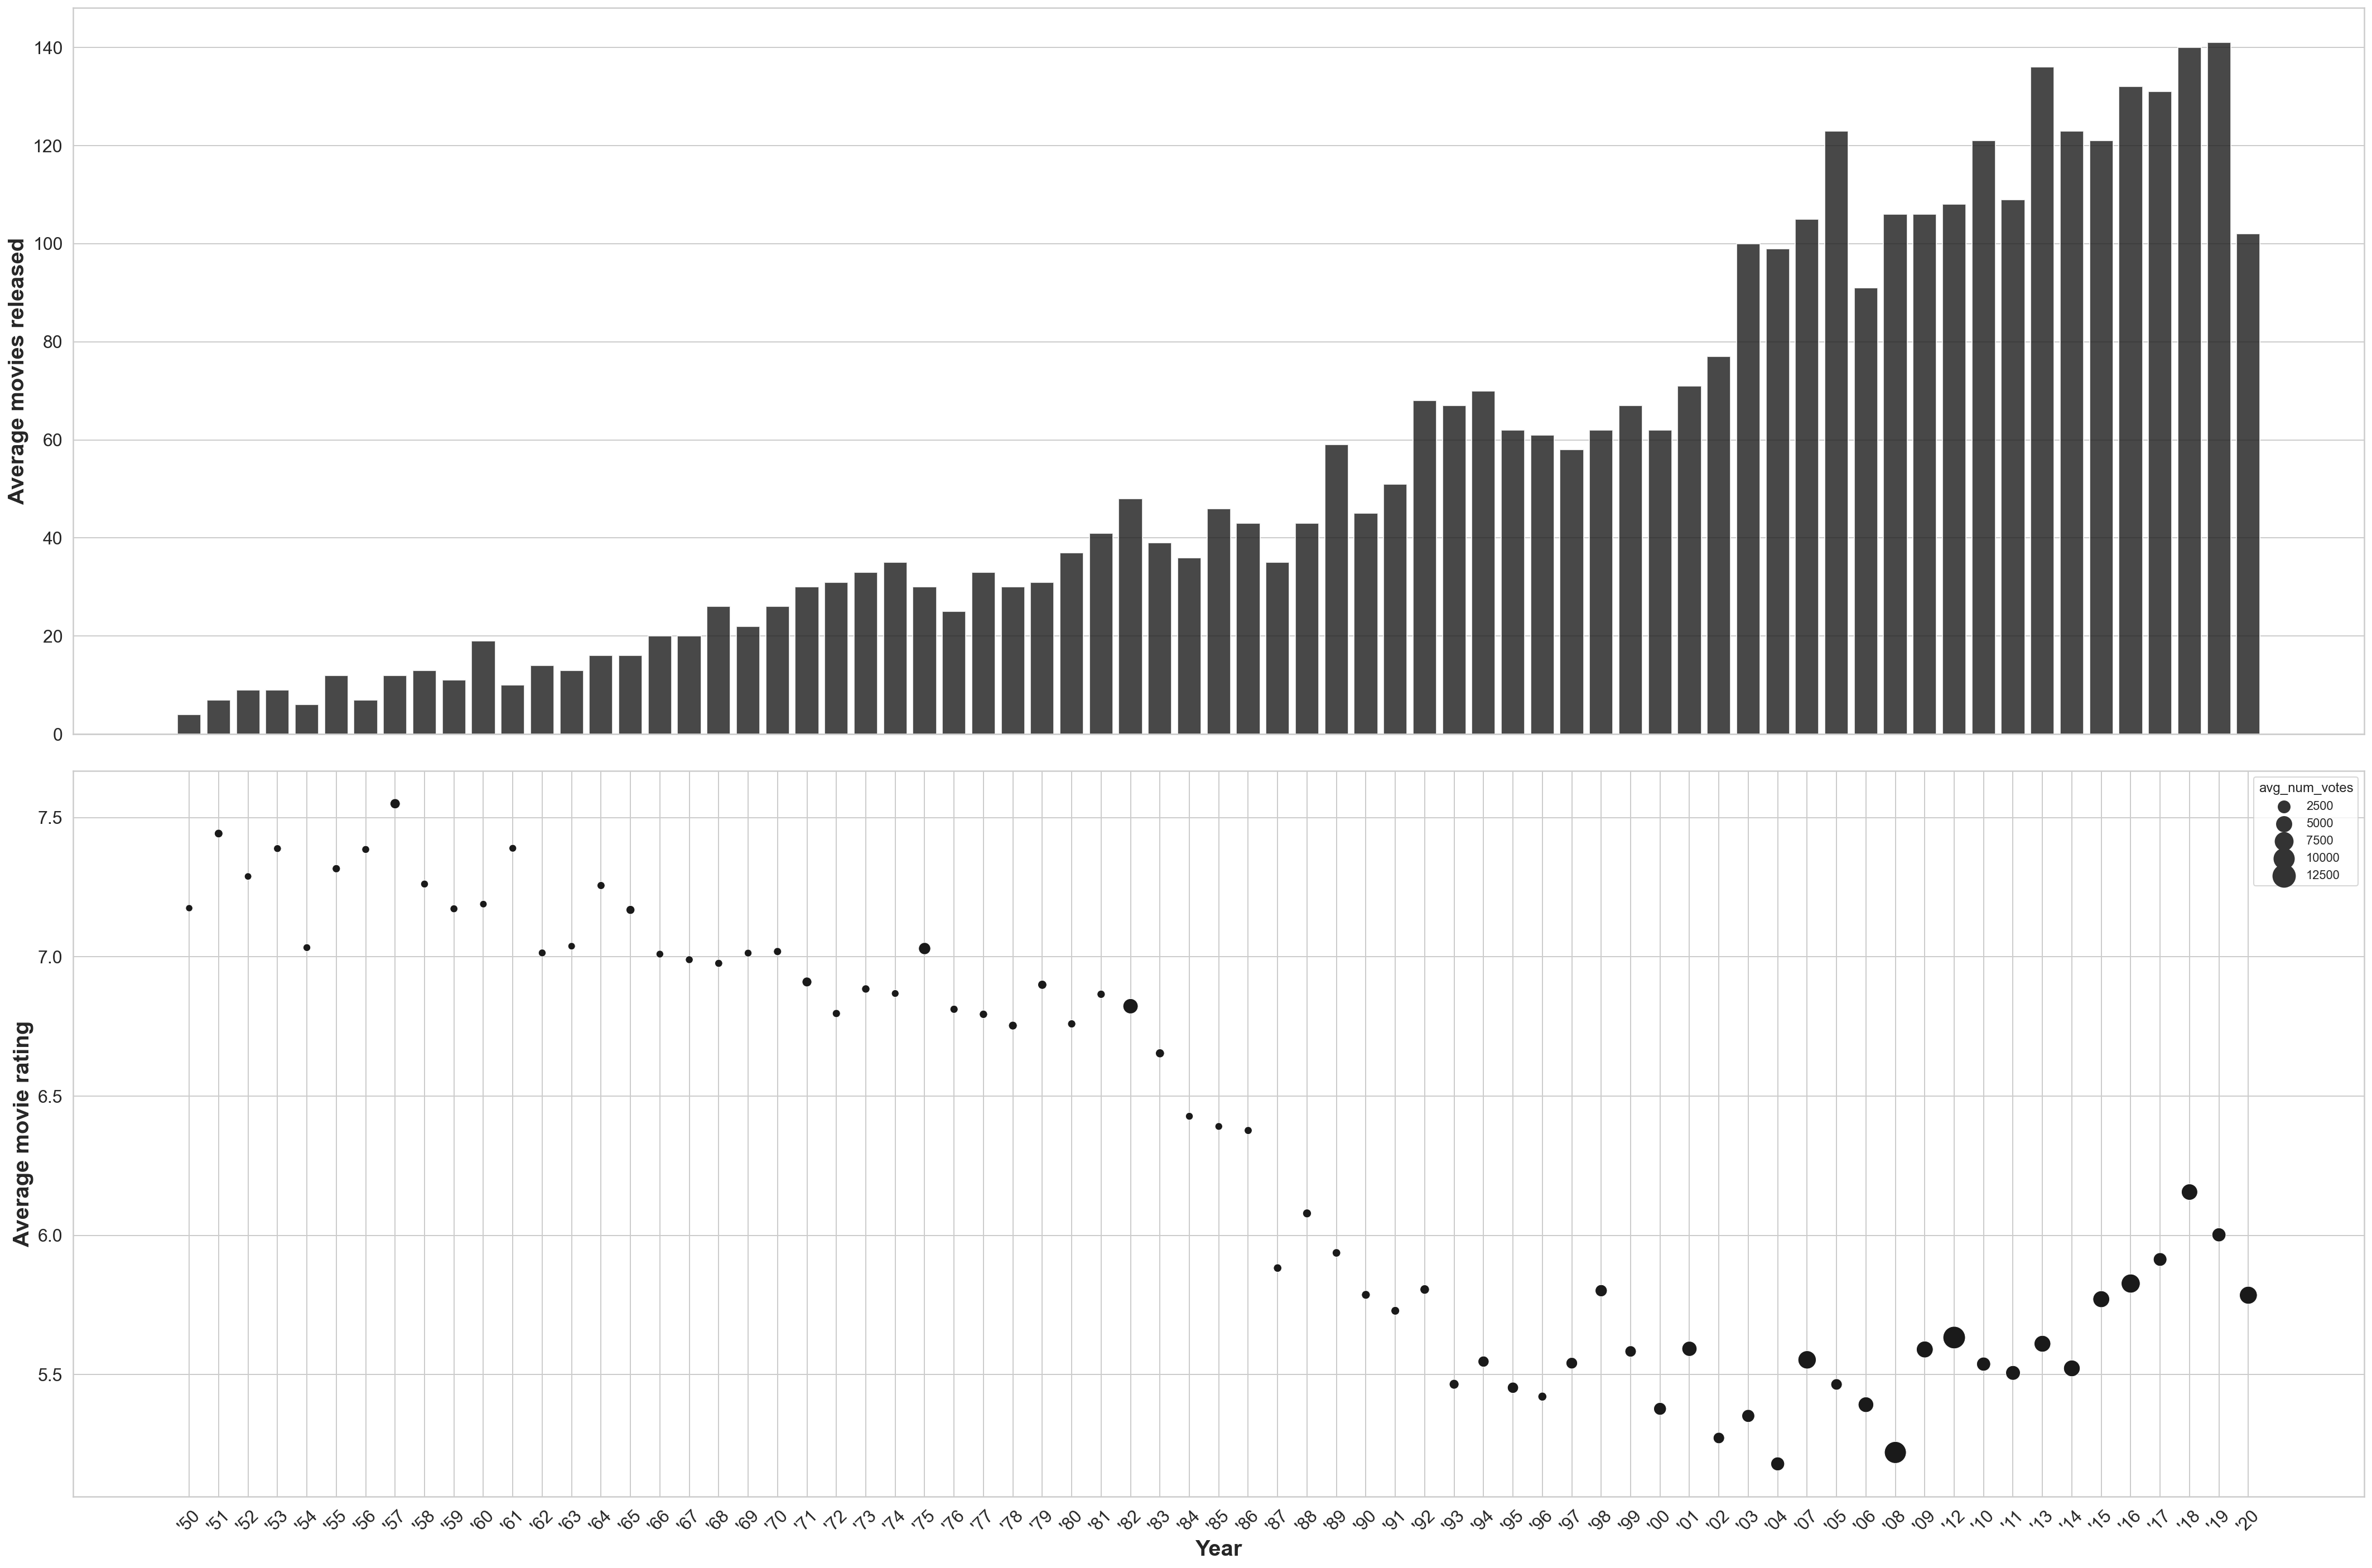

In [28]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(30,20), sharex=True)
year_list = ["'{}".format(str(value)[2:]) for value in df_annual_movie_stats.year.to_list()]
sns.barplot(x=year_list, y='total_movies_year', color='k', alpha=0.8, data=df_annual_movie_stats, ax=ax1)
ax1.set_ylabel('Average movies released')

sns.scatterplot(year_list, 'avg_movie_rating', size='avg_num_votes', color='k', sizes=(40, 400), data=df_annual_movie_stats, ax=ax2);
ax2.set_xlabel('Year')
ax2.set_ylabel('Average movie rating')
ax2.get_legend()
for item in ax2.get_xticklabels():
    item.set_rotation(45)
    
plt.tight_layout()

The two plots show the number of films released each year and the average IMDb rating for the movies released in that year. Now we might conclude that movies are getting selectively worse in spite of there being more movies being released, however the confidence in that statement is difficult to justify since the number of votes casted in these movies is an important parameter to keep in mind.

## Sort the movies released as per decades 

Define a new column here as per decade to condense the analysis
```python
10 * (df_annual_movie_stats['year']//10)
```
This line converts years to a decade entry 

In [29]:
df_annual_movie_stats['decade'] = 10 * (df_annual_movie_stats['year']//10)

In [30]:
df_annual_movie_stats_decade = df_annual_movie_stats.groupby(['decade']).mean()

In [31]:
df_annual_movie_stats_decade.sample(5)

,year,total_movies_year,movie_rating,avg_num_votes,avg_movie_rating
decade,,,,,
2000,2004.5,94.0,8.46,5160.443252,5.399690
2010,2014.5,126.2,8.44,6305.900985,5.748150
2020,2020.0,102.0,8.90,7485.009804,5.785294
1960,1964.5,17.6,8.15,326.809100,7.104778
1970,1974.5,30.4,8.18,820.688426,6.876870


In [32]:
df_annual_movie_stats_decade.index

Int64Index([1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020], dtype='int64', name='decade')

In [34]:
decade_list = ["{}s".format(str(value)[2:]) for value in df_annual_movie_stats_decade.index.to_list()]

/Users/pghaneka/miniconda3/envs/doodle/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


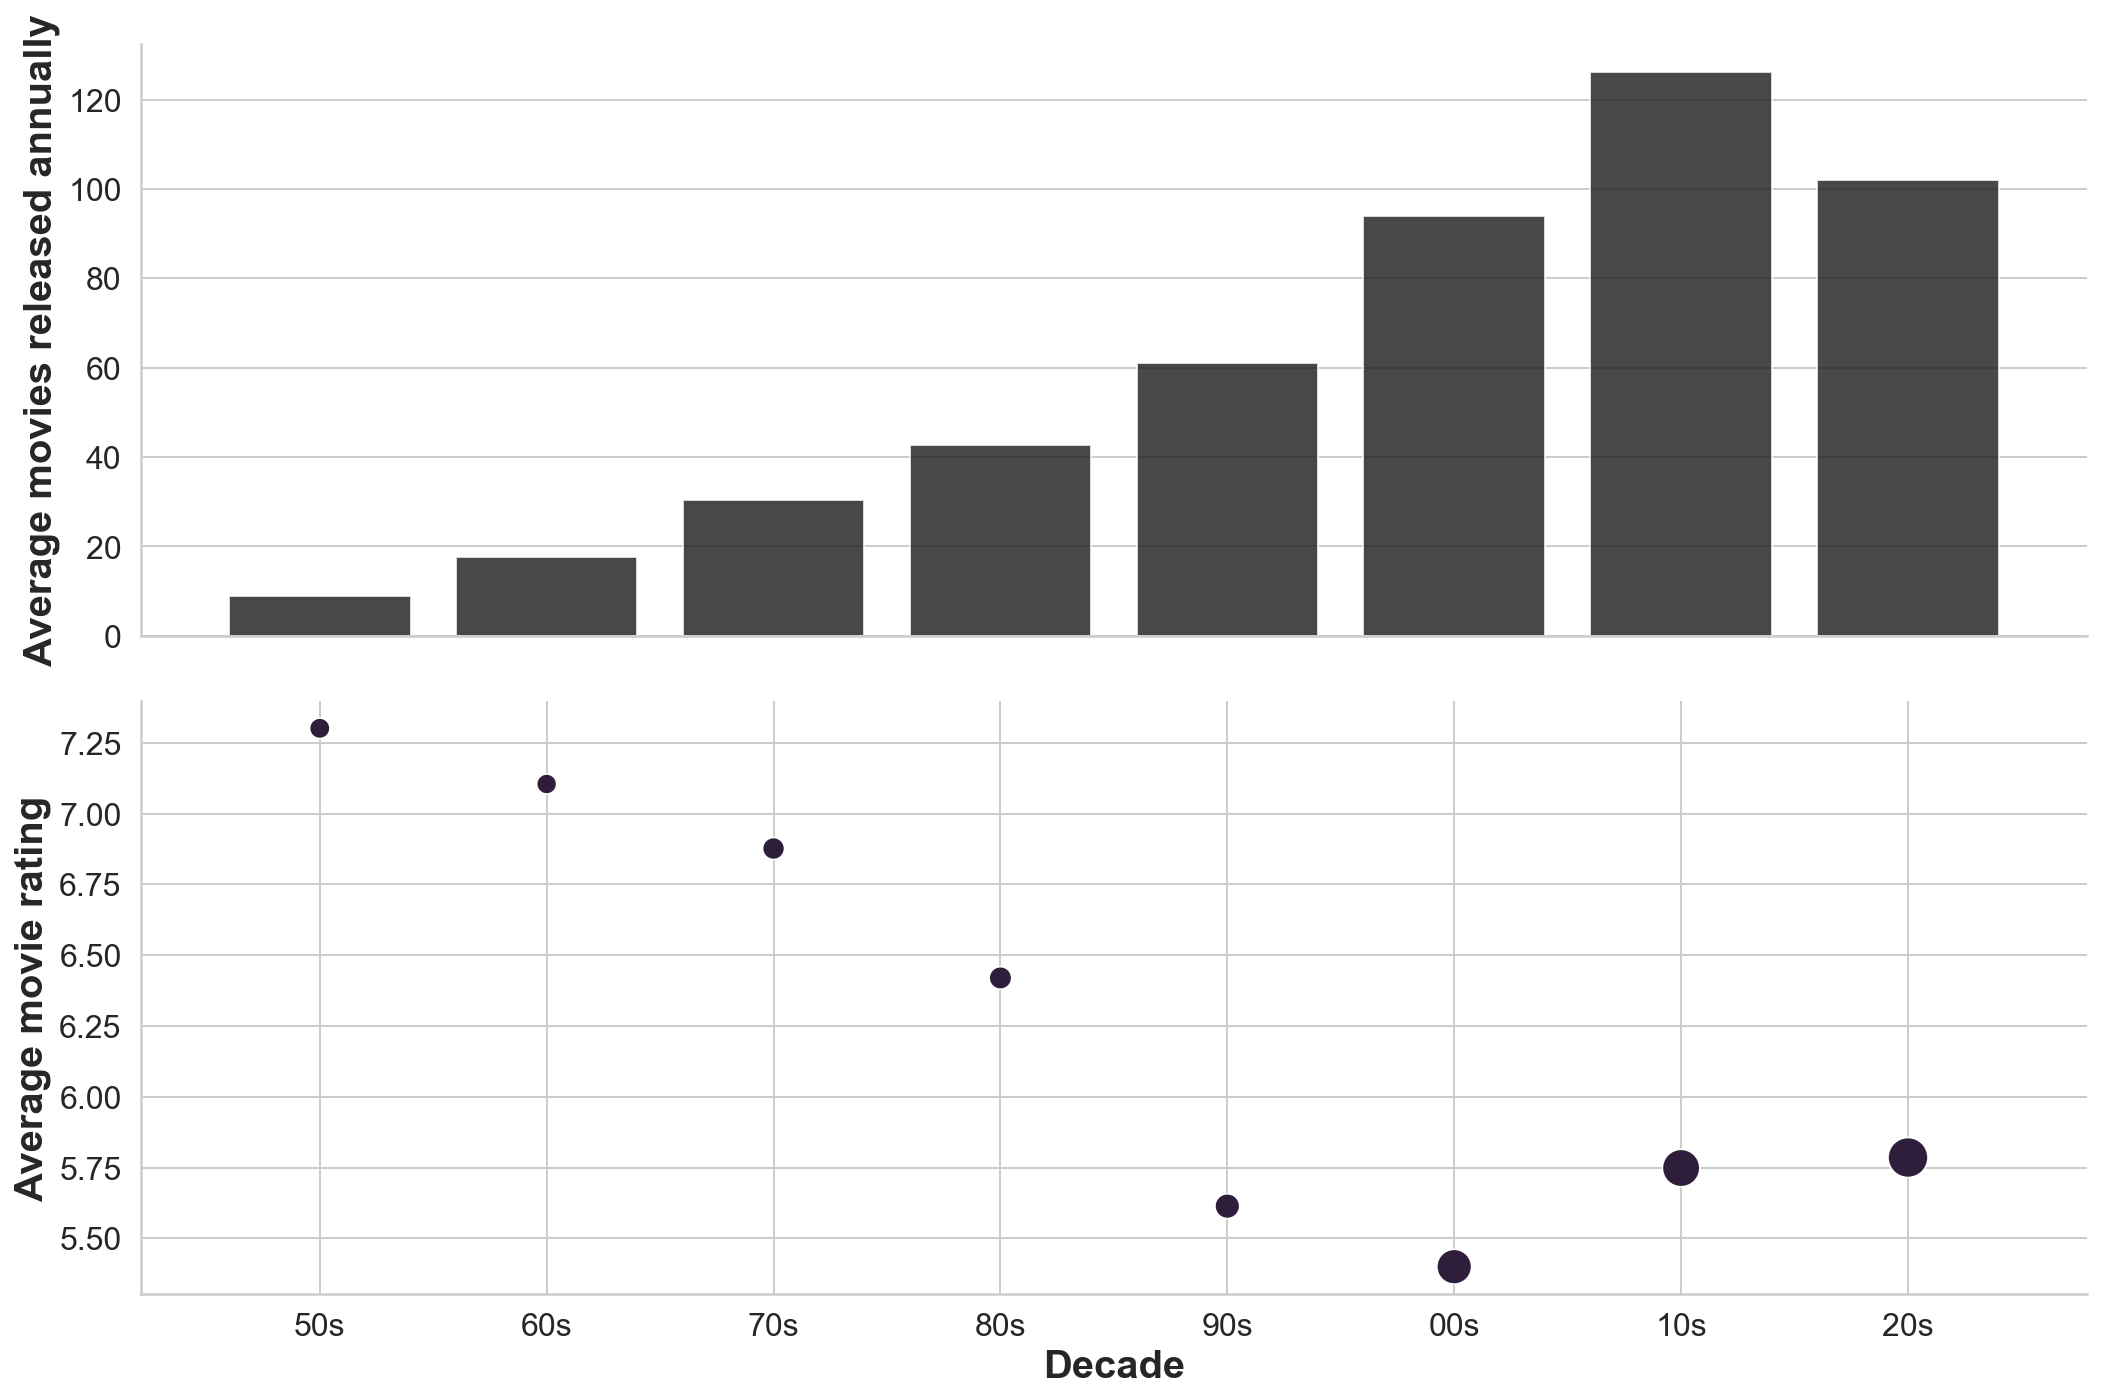

In [38]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(15,10), sharex=True)

sns.barplot(x=decade_list, y='total_movies_year', data=df_annual_movie_stats_decade, color='k', alpha=0.8, ax=ax1)
ax1.set_ylabel('Average movies released annually')

sns.scatterplot(decade_list, 'avg_movie_rating', size='avg_num_votes', sizes=(100, 400), data=df_annual_movie_stats_decade, ax=ax2);
sns.despine()

ax2.set_xlabel('Decade')
ax2.set_ylabel('Average movie rating')
ax2.get_legend().remove()

plt.tight_layout()